## In this notebook:
* Analysis of TCGA dataset containing gene expression values for both normal and cancer cells.
* Cancer type is clear cell renal carcinoma (kidney cancer)
* The dataset can be found at: https://tcga.xenahubs.net/download/TCGA.KIRC.sampleMap/HiSeqV2.gz
* Brief discussion of the goal of this project and the workflow
* Data wrangling
* Data filtering
* EDA
* Differential expression analysis
* Interpretation of results


### Analysis of TCGA gene expression dataset for clear cell renal carcinoma.

The goal of this analysis is to find differences in gene expression profiles between the two sample populations: normal cells vs cancer cells. The two groups will be compared through an analysis of a gene expression dataset downloaded from The Cancer Genome Atlas (TCGA). The dataset contains expression values (sequence counts) generated via the Illumina HiSeq platform. 


### Summary of the Differential Expression Analysis Workflow:

1) Involves identifying genes whose expression levels change between two sample groups.

2) We begin by importing our dataset and necessary packages.

3) Then, we can reduce our dataset by filtering out all genes with zero values.

4) Next, we can split our dataset using regular expressions:

    a) Expression values for cancer cells in one dataframe
    
    b) Expression values for normal cells in another dataframe

5) Because the dataset has already been normalized and log(2) transformed, no additional preprocessing is required.

6) We can further truncate our dataset using the IQR method. However, for this demonstration, we only reduce the dataset through filtering out all genes with zero values. 

7) The differential expression (DE) workflow:

    a) Calculate the mean for each row (or each gene) in both dataframes
    
    b) calculate the variance for each row in both dataframes
    
    c) Calculate the t-statistic for each gene across both dataframes
    
    d) Because we have a large number of replicates for each group and only two groups, the t-statistic can be used

8) Show the top 25 differentially expressed genes

9) There are many packages designed to perform DE analysis. We could use the many R packages available  (such as edgeR) and utilize rpy2 to call R from python, or we could use python packages such as HTSeq. However, one of our goals in this case is to perform DE analysis using only pythonic techniques. 

## Data wrangling

In [27]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
 
%matplotlib inline
 
print("Current working directory" , os.getcwd()) # print out current working directory

Current working directory c:\users\frank\desktop\python_springboard\datasets


### Read in data and print header

In [28]:
os.chdir('c:/users/frank/desktop/python_springboard/datasets')

In [29]:
filename = 'HiSeqV2.csv' # assign dataset to filename object
data = pd.read_csv(filename, sep = ',') # read in csv file as pandas dataframe

In [30]:
data = data.set_index('sample')

In [31]:
data.head() # print head to verify proper formatting 

,TCGA-BP-4162-01,TCGA-CJ-5677-11,TCGA-DV-5566-01,TCGA-BP-5191-01,TCGA-BP-5200-01,TCGA-BP-4347-01,TCGA-BP-4770-01,TCGA-B0-5696-11,TCGA-BP-4762-01,TCGA-BP-4158-01,...,TCGA-B0-5104-01,TCGA-A3-3313-01,TCGA-B2-5633-01,TCGA-CJ-4872-01,TCGA-CJ-5684-01,TCGA-CJ-4886-01,TCGA-BP-5009-01,TCGA-BP-4969-01,TCGA-CZ-5461-01,TCGA-CW-5587-01
sample,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,10.5030,10.8969,10.7612,10.2063,10.0616,10.0193,8.4364,11.1427,9.9150,10.7621,...,10.5586,9.5556,10.2652,9.4981,10.2751,9.9525,10.1273,10.8817,10.1949,10.3294
HIF3A,5.5283,6.4943,5.7842,5.0063,5.3326,7.6102,6.0422,5.9789,3.7802,7.2039,...,6.2061,4.8253,5.1680,8.6195,6.2080,6.3116,6.7446,7.8293,6.1788,6.2293
RNF17,3.8036,0.0000,0.0000,0.0000,0.0000,0.3386,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6128,0.0000
RNF10,11.4379,12.2130,11.5478,12.3439,11.5149,11.4065,12.1963,12.3946,11.3734,11.3251,...,11.7338,11.7709,11.4968,11.9561,11.7518,11.5698,12.1565,11.3048,11.5168,11.3489
RNF11,11.4180,11.8248,11.3190,10.3413,11.2923,10.9971,11.8936,11.7217,12.2329,11.2993,...,11.7629,10.2373,11.4637,11.4391,11.3992,11.4937,11.4015,10.8842,11.6230,11.5469


### Drop rows with zero values

In [13]:
df_replace = data.replace(0.0000, np.nan)
df_dropped = df_replace.dropna(axis=0, how='any')
df_dropped.shape

(12580, 606)

### Split data into two dataframes:
* The first dataframe (df1) contains expression values for normal cells
* The second dataframe (df2) contains expression values for cancer cells

In [14]:
df1 = df_dropped.filter(regex = 'sample|11$', axis =1)
# Creating new dataframe with only columns containing expression values for normal cells

In [15]:
df1.shape

(12580, 72)

In [16]:
df1.head()

,TCGA-CJ-5677-11,TCGA-B0-5696-11,TCGA-CJ-5679-11,TCGA-CZ-5452-11,TCGA-B0-5712-11,TCGA-CW-5584-11,TCGA-B0-5701-11,TCGA-CZ-5461-11,TCGA-B0-5690-11,TCGA-CZ-5468-11,...,TCGA-CW-5580-11,TCGA-B8-5552-11,TCGA-CZ-4865-11,TCGA-CZ-4863-11,TCGA-B2-5636-11,TCGA-CW-6088-11,TCGA-CZ-5982-11,TCGA-CZ-5469-11,TCGA-CJ-5678-11,TCGA-CZ-5451-11
sample,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,10.8969,11.1427,10.3362,10.9979,10.6467,10.6163,10.6772,10.5352,10.9610,10.8893,...,10.8603,9.4288,10.3868,10.2874,10.9476,10.8848,10.7783,10.3262,10.4025,10.9598
HIF3A,6.4943,5.9789,6.0228,7.8769,8.5452,5.1819,8.6367,4.9484,7.1702,7.2163,...,8.3424,5.5908,7.9224,7.5603,6.4780,8.5598,6.5021,6.9556,5.5893,6.8364
RNF10,12.2130,12.3946,12.3002,12.4976,12.1206,12.1293,12.1640,12.2868,12.2738,12.2829,...,12.4214,11.3729,11.9933,11.9568,12.1550,12.4600,12.0911,12.3941,12.0396,12.2514
RNF11,11.8248,11.7217,12.0602,11.6335,11.8102,11.6994,11.5128,11.9681,11.5019,11.7200,...,11.6284,12.6320,11.9769,11.9774,11.6255,11.4753,11.9079,11.7476,11.9066,11.7847
RNF13,10.7779,10.8412,10.8172,10.9679,10.7033,10.6184,10.7271,11.0801,10.9754,10.7149,...,11.0227,11.2715,11.0244,10.7831,10.8893,10.9174,10.8537,10.6932,11.0341,10.9808


In [17]:
df2 = df_dropped.filter(regex = 'sample|01|05$', axis = 1)
# Creating new dataframe with only columns containing expression values for cancer cells

In [18]:
df2.shape

(12580, 535)

In [19]:
df2.head()

,TCGA-BP-4162-01,TCGA-DV-5566-01,TCGA-BP-5191-01,TCGA-BP-5200-01,TCGA-BP-4347-01,TCGA-BP-4770-01,TCGA-BP-4762-01,TCGA-BP-4158-01,TCGA-CJ-4887-01,TCGA-B2-4098-01,...,TCGA-B0-5104-01,TCGA-A3-3313-01,TCGA-B2-5633-01,TCGA-CJ-4872-01,TCGA-CJ-5684-01,TCGA-CJ-4886-01,TCGA-BP-5009-01,TCGA-BP-4969-01,TCGA-CZ-5461-01,TCGA-CW-5587-01
sample,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,10.5030,10.7612,10.2063,10.0616,10.0193,8.4364,9.9150,10.7621,10.5819,9.9260,...,10.5586,9.5556,10.2652,9.4981,10.2751,9.9525,10.1273,10.8817,10.1949,10.3294
HIF3A,5.5283,5.7842,5.0063,5.3326,7.6102,6.0422,3.7802,7.2039,6.1342,1.9065,...,6.2061,4.8253,5.1680,8.6195,6.2080,6.3116,6.7446,7.8293,6.1788,6.2293
RNF10,11.4379,11.5478,12.3439,11.5149,11.4065,12.1963,11.3734,11.3251,11.7681,11.7520,...,11.7338,11.7709,11.4968,11.9561,11.7518,11.5698,12.1565,11.3048,11.5168,11.3489
RNF11,11.4180,11.3190,10.3413,11.2923,10.9971,11.8936,12.2329,11.2993,10.8723,10.4091,...,11.7629,10.2373,11.4637,11.4391,11.3992,11.4937,11.4015,10.8842,11.6230,11.5469
RNF13,11.1265,10.7718,10.4809,10.8360,10.2079,9.7629,11.1625,10.6960,10.8856,11.5110,...,11.2131,11.5131,11.0412,11.1944,10.9735,11.1726,10.9264,10.9815,10.7416,11.0906


## Generate density plots to confirm the shape of the distribution

#### KDE plots of processed data separated by sample type (cancer/normal)

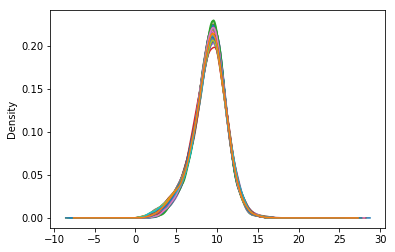

In [20]:
df1.plot(kind='kde', legend=False) # normal cells

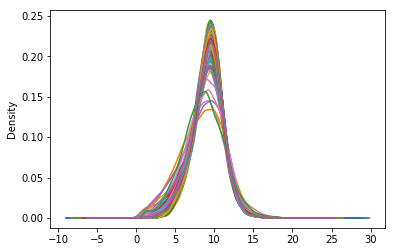

In [23]:
df2.plot(kind='kde', legend=False) # cancer cells

## Pythonic differential expression analysis

In [68]:
import warnings
warnings.simplefilter("ignore")
from scipy.stats import ttest_ind, ttest_ind_from_stats


df1['mean1'] = df1[df1.columns].mean(axis=1)
df1['variance1'] = df1[df1.columns].var(axis=1)
df2['mean2'] = df2[df2.columns].mean(axis=1)
df2['variance2'] = df2[df2.columns].var(axis=1)



In [69]:
df1.head()

,TCGA-CJ-5677-11,TCGA-B0-5696-11,TCGA-CJ-5679-11,TCGA-CZ-5452-11,TCGA-B0-5712-11,TCGA-CW-5584-11,TCGA-B0-5701-11,TCGA-CZ-5461-11,TCGA-B0-5690-11,TCGA-CZ-5468-11,...,TCGA-B2-5636-11,TCGA-CW-6088-11,TCGA-CZ-5982-11,TCGA-CZ-5469-11,TCGA-CJ-5678-11,TCGA-CZ-5451-11,mean,variance,mean1,variance1
sample,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,10.8969,11.1427,10.3362,10.9979,10.6467,10.6163,10.6772,10.5352,10.9610,10.8893,...,10.9476,10.8848,10.7783,10.3262,10.4025,10.9598,10.587401,0.124498,10.446011,1.580498
HIF3A,6.4943,5.9789,6.0228,7.8769,8.5452,5.1819,8.6367,4.9484,7.1702,7.2163,...,6.4780,8.5598,6.5021,6.9556,5.5893,6.8364,6.844586,0.760941,6.762375,1.233761
RNF10,12.2130,12.3946,12.3002,12.4976,12.1206,12.1293,12.1640,12.2868,12.2738,12.2829,...,12.1550,12.4600,12.0911,12.3941,12.0396,12.2514,12.214072,0.057677,12.049797,2.026131
RNF11,11.8248,11.7217,12.0602,11.6335,11.8102,11.6994,11.5128,11.9681,11.5019,11.7200,...,11.6255,11.4753,11.9079,11.7476,11.9066,11.7847,11.827933,0.047012,11.668732,1.895938
RNF13,10.7779,10.8412,10.8172,10.9679,10.7033,10.6184,10.7271,11.0801,10.9754,10.7149,...,10.8893,10.9174,10.8537,10.6932,11.0341,10.9808,10.933962,0.038483,10.786726,1.619974


In [70]:
df2.head()

,TCGA-BP-4162-01,TCGA-DV-5566-01,TCGA-BP-5191-01,TCGA-BP-5200-01,TCGA-BP-4347-01,TCGA-BP-4770-01,TCGA-BP-4762-01,TCGA-BP-4158-01,TCGA-CJ-4887-01,TCGA-B2-4098-01,...,TCGA-CJ-5684-01,TCGA-CJ-4886-01,TCGA-BP-5009-01,TCGA-BP-4969-01,TCGA-CZ-5461-01,TCGA-CW-5587-01,mean,variance,mean2,variance2
sample,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,10.5030,10.7612,10.2063,10.0616,10.0193,8.4364,9.9150,10.7621,10.5819,9.9260,...,10.2751,9.9525,10.1273,10.8817,10.1949,10.3294,10.132370,0.506471,10.114445,0.676811
HIF3A,5.5283,5.7842,5.0063,5.3326,7.6102,6.0422,3.7802,7.2039,6.1342,1.9065,...,6.2080,6.3116,6.7446,7.8293,6.1788,6.2293,6.221919,2.489839,6.214969,2.506455
RNF10,11.4379,11.5478,12.3439,11.5149,11.4065,12.1963,11.3734,11.3251,11.7681,11.7520,...,11.7518,11.5698,12.1565,11.3048,11.5168,11.3489,11.675401,0.102617,11.653851,0.351174
RNF11,11.4180,11.3190,10.3413,11.2923,10.9971,11.8936,12.2329,11.2993,10.8723,10.4091,...,11.3992,11.4937,11.4015,10.8842,11.6230,11.5469,11.322741,0.198024,11.302025,0.427322
RNF13,11.1265,10.7718,10.4809,10.8360,10.2079,9.7629,11.1625,10.6960,10.8856,11.5110,...,10.9735,11.1726,10.9264,10.9815,10.7416,11.0906,10.980765,0.231565,10.960748,0.445471


In [71]:
df1_stats = df1[['mean1', 'variance1']]
df1_stats.head()

,mean1,variance1
sample,,
ARHGEF10L,10.446011,1.580498
HIF3A,6.762375,1.233761
RNF10,12.049797,2.026131
RNF11,11.668732,1.895938
RNF13,10.786726,1.619974


In [72]:
df2_stats = df2[['mean2', 'variance2']]
df2_stats.head()

,mean2,variance2
sample,,
ARHGEF10L,10.114445,0.676811
HIF3A,6.214969,2.506455
RNF10,11.653851,0.351174
RNF11,11.302025,0.427322
RNF13,10.960748,0.445471


In [77]:
df = pd.concat([df1_stats, df2_stats], axis=1)
df.head()

,mean1,variance1,mean2,variance2
sample,,,,
ARHGEF10L,10.446011,1.580498,10.114445,0.676811
HIF3A,6.762375,1.233761,6.214969,2.506455
RNF10,12.049797,2.026131,11.653851,0.351174
RNF11,11.668732,1.895938,11.302025,0.427322
RNF13,10.786726,1.619974,10.960748,0.445471


In [79]:
df1.shape

(12580, 76)

In [80]:
df2.shape

(12580, 539)

In [86]:
df['ttest'] = abs((df['mean1'] - df['mean2'])/(np.sqrt(df['variance1']/76 + df['variance2']/539)))

In [87]:
df.head()

,mean1,variance1,mean2,variance2,ttest
sample,,,,,
ARHGEF10L,10.446011,1.580498,10.114445,0.676811,2.232797
HIF3A,6.762375,1.233761,6.214969,2.506455,3.787943
RNF10,12.049797,2.026131,11.653851,0.351174,2.395886
RNF11,11.668732,1.895938,11.302025,0.427322,2.285704
RNF13,10.786726,1.619974,10.960748,0.445471,1.169488


In [100]:
diffexp_results = df['ttest']
diffexp = diffexp_results.sort_values(ascending=False)
diffexp.head()

sample
PVT1        37.838876
NDUFA4L2    37.531882
GABRD       37.306219
DOC2A       35.563927
C20orf46    34.408641
Name: ttest, dtype: float64

In [105]:
results = diffexp.iloc[1:25]
results

sample
NDUFA4L2    37.531882
GABRD       37.306219
DOC2A       35.563927
C20orf46    34.408641
C7orf68     33.649802
SPAG4       33.360194
CDCA2       32.098709
COL23A1     31.607332
PAK6        31.372272
RAB42       30.963189
HSF4        30.504236
PROM2       29.673042
SFRP1       29.246257
APOC1       28.840628
SCARB1      28.501039
NXPH4       28.045206
TFCP2L1     27.884107
C9orf100    27.524104
TMEM91      27.487886
TREM2       27.262329
NOL3        27.159604
OTOA        27.049622
SDS         26.988796
EGLN3       26.906806
Name: ttest, dtype: float64